In [1]:

import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import numpy as np
import os, cv2

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(4 * n_col, 4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())




In [2]:
dir_name="dataset/faces/"
y=[]; X=[]; target_names=[]
person_id=0; h=w=300
n_samples=0
class_names=[]

for person_name in os.listdir(dir_name):
    # print(person_name)
    dir_path = dir_name + person_name + "/"
    class_names.append(person_name)
    
    for image_name in os.listdir(dir_path):
        # formulate the image path
        image_path = dir_path + image_name
        # Read the input image
        img = cv2.imread(image_path)
        # Convert into grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # resize image to 300*300 dimension
        resized_image = cv2.resize(gray, (h, w))
        # Convert matrix to vector
        v = resized_image.flatten()
        X.append(v)
        
        # Increase the number of samples
        n_samples = n_samples + 1
        # Adding the categorical label
        y.append(person_id)
        target_names.append(person_name)

    person_id += 1

y = np.array(y)
X = np.array(X)

target_names = np.array(target_names)
n_features = X.shape[1]

print(y.shape, X.shape, target_names.shape)
print("Number of samples:", n_samples)
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)




(450,) (450, 90000) (450,)
Number of samples: 450
Total dataset size:
n_samples: 450
n_features: 90000
n_classes: 450


Extracting the top 150 eigenfaces from 337 faces


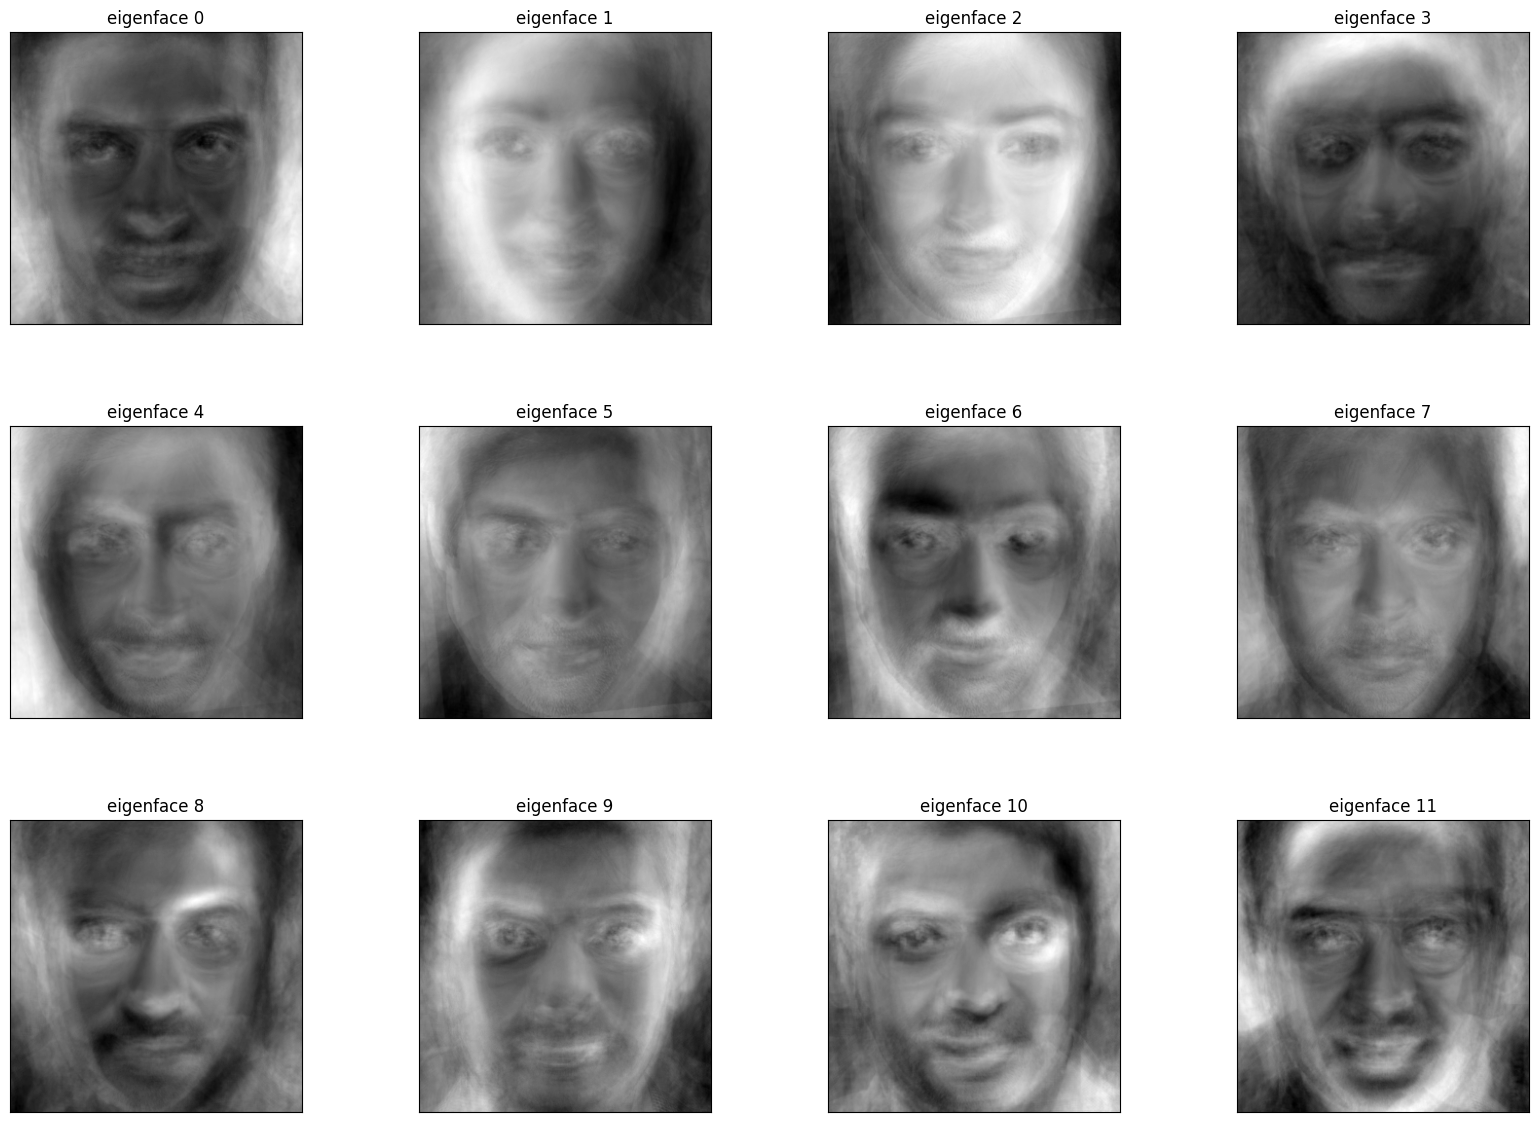

Projecting the input data on the eigenfaces orthonormal basis
(337, 150) (113, 150)


In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))

# Applying PCA
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

# Generating eigenfaces
eigenfaces = pca.components_.reshape((n_components, h, w))

# Plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape, X_test_pca.shape)

# %%Compute Fisherfaces
lda = LinearDiscriminantAnalysis()
# Compute LDA of reduced data
lda.fit(X_train_pca, y_train)

X_train_lda = lda.transform(X_train_pca)
X_test_lda = lda.transform(X_test_pca)

In [4]:
clf = MLPClassifier(random_state=1, hidden_layer_sizes=(10,10), max_iter=1000, verbose=True).fit(X_train_lda, y_train)
print("Model weights:")
model_info = [coef.shape for coef in clf.coefs_]
print(model_info)

Iteration 1, loss = 3.11745188
Iteration 2, loss = 3.05778654
Iteration 3, loss = 3.00424804
Iteration 4, loss = 2.94837331
Iteration 5, loss = 2.89316321
Iteration 6, loss = 2.84164832
Iteration 7, loss = 2.78881123
Iteration 8, loss = 2.73786514
Iteration 9, loss = 2.68938571
Iteration 10, loss = 2.64083014
Iteration 11, loss = 2.59312353
Iteration 12, loss = 2.54841325
Iteration 13, loss = 2.50255336
Iteration 14, loss = 2.45975248
Iteration 15, loss = 2.41591258
Iteration 16, loss = 2.37408540
Iteration 17, loss = 2.33433981
Iteration 18, loss = 2.29297698
Iteration 19, loss = 2.25719663
Iteration 20, loss = 2.21891987
Iteration 21, loss = 2.18425511
Iteration 22, loss = 2.14850705
Iteration 23, loss = 2.11413243
Iteration 24, loss = 2.08087437
Iteration 25, loss = 2.04858822
Iteration 26, loss = 2.01734134
Iteration 27, loss = 1.98534055
Iteration 28, loss = 1.95451210
Iteration 29, loss = 1.92413398
Iteration 30, loss = 1.89395994
Iteration 31, loss = 1.86506845
Iteration 32, los

Accuracy: 73.45132743362832


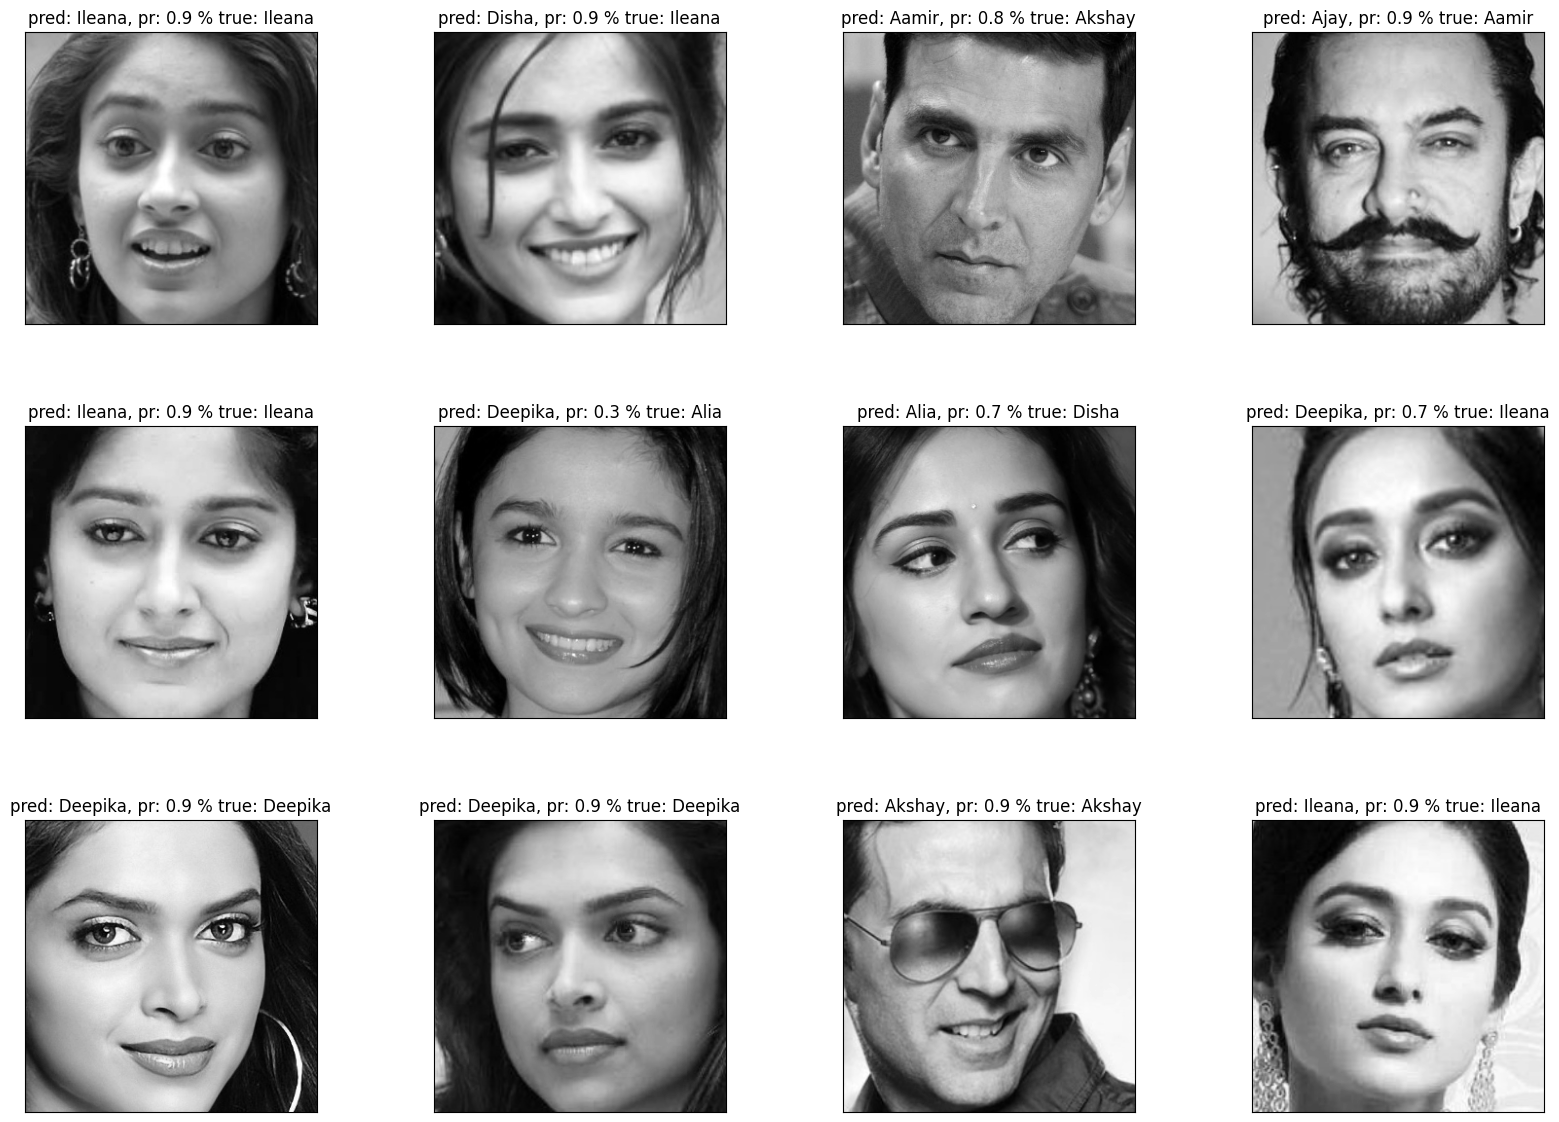

In [5]:
y_pred=[]; y_prob=[]
for test_face in X_test_lda:
    prob = clf.predict_proba([test_face])[0]
    # print(prob, np.max(prob))
    class_id = np.where(prob == np.max(prob))[0][0]
    # print(class_index)
    # Find the label of the matched face
    y_pred.append(class_id)
    y_prob.append(np.max(prob))

# Transform the data
y_pred = np.array(y_pred)

prediction_titles = []
true_positive = 0
for i in range(y_pred.shape[0]):
    # print(y_test[i], y_pred[i])
    # true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    # pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = class_names[y_test[i]]
    pred_name = class_names[y_pred[i]]
    result = 'pred: %s, pr: %s %% true: %s' % (pred_name, str(y_prob[i])[0:3], true_name)
    # result = 'prediction: %s true: %s' % (pred_name, true_name)
    prediction_titles.append(result)
    if true_name == pred_name:
        true_positive += 1

print("Accuracy:", true_positive * 100 / y_pred.shape[0])

# Plot results
plot_gallery(X_test, prediction_titles, h, w)
plt.show()
